In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import os

# Activation Functions

In [17]:
def logit(z):
    return 1 / (1 + np.exp(-z))

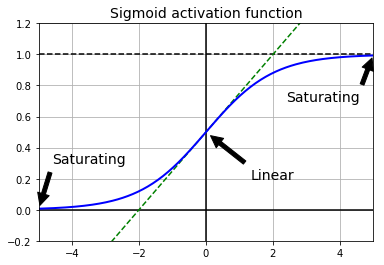

In [18]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [19]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

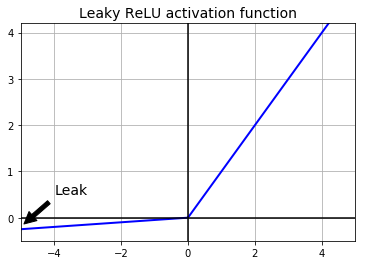

In [20]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [21]:
def elu(z, alpha=1):
    return np.where(z<0, alpha*(np.exp(z)-1), z)

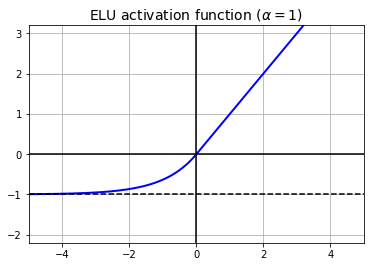

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [24]:
def leaky_relu(z, name=None):
  return tf.maximum(0.01 * z, z, name=name)

In [25]:
import tensorflow as tf

In [26]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [27]:
tf.reset_default_graph()

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.69 Test accuracy: 0.7114
1 Train accuracy: 0.77 Test accuracy: 0.8165
2 Train accuracy: 0.79 Test accuracy: 0.8479
3 Train accuracy: 0.86 Test accuracy: 0.8637
4 Train accuracy: 0.92 Test accuracy: 0.8746
5 Train accuracy: 0.86 Test accuracy: 0.8851
6 Train accuracy: 0.91 Test accuracy: 0.8896
7 Train accuracy: 0.92 Test accuracy: 0.8945
8 Train accuracy: 0.89 Test accuracy: 0.8995
9 Train accuracy: 0.83 Test accuracy: 0.9006
10 Train accuracy: 0.95 Test accuracy: 0.9043
11 Train accuracy: 0.92 Test accuracy: 0.9066
12 Train accuracy: 0.92 Test accuracy: 0.9092
13 Train accuracy: 0.87 Test accuracy: 0.911
14 Train accuracy: 0.87 Test accuracy: 0.9126
15 Train accuracy: 0.9 Test accuracy: 0.914
16 Train accuracy: 0.9 Test accuracy: 0.9157
17 Train accuracy: 0.9 Test accuracy: 0.9172
18 Train accuracy: 0.89 Test accuracy: 0.92
19 Train accuracy: 0.89 Test accuracy: 0.9193


In [30]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
learning_rate = 0.01
momentum = 0.25

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=is_training,
            momentum=0.9)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, activation=None, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops], feed_dict={is_training: True, X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={is_training: False, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={is_training: False, X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.78 Test accuracy: 0.7674
1 Train accuracy: 0.82 Test accuracy: 0.8278
2 Train accuracy: 0.82 Test accuracy: 0.8494
3 Train accuracy: 0.855 Test accuracy: 0.8629
4 Train accuracy: 0.87 Test accuracy: 0.8741
5 Train accuracy: 0.885 Test accuracy: 0.8841
6 Train accuracy: 0.86 Test accuracy: 0.8902
7 Train accuracy: 0.885 Test accuracy: 0.8966
8 Train accuracy: 0.93 Test accuracy: 0.8989
9 Train accuracy: 0.885 Test accuracy: 0.905
10 Train accuracy: 0.925 Test accuracy: 0.9081
11 Train accuracy: 0.9 Test accuracy: 0.9101
12 Train accuracy: 0.925 Test accuracy: 0.9123
13 Train accuracy: 0.9 Test accuracy: 0.9149
14 Train accuracy: 0.94 Test accuracy: 0.9153
15 Train accuracy: 0.94 Test accuracy: 0.9191
16 Train accuracy: 0.9 Test accuracy: 0.92
17 Train accuracy: 0.925 Test accuracy: 0.9211
18 Train accuracy: 0.92 Test accuracy: 0.9232
19 Train accuracy: 0.965 Test accuracy: 0.9266


### Now the same model with L1 regularization:

In [33]:
tf.reset_default_graph()

from functools import partial

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=is_training,
            momentum=0.9)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init,
            kernel_regularizer=tf.contrib.layers.l1_regularizer(0.01))

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, activation=None, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    base_loss = tf.reduce_mean(xentropy, name="base_loss")
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops], feed_dict={is_training: True, X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={is_training: False, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={is_training: False, X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.715 Test accuracy: 0.7797
1 Train accuracy: 0.795 Test accuracy: 0.8424
2 Train accuracy: 0.895 Test accuracy: 0.863
3 Train accuracy: 0.85 Test accuracy: 0.8765
4 Train accuracy: 0.885 Test accuracy: 0.8881
5 Train accuracy: 0.92 Test accuracy: 0.8962
6 Train accuracy: 0.925 Test accuracy: 0.9001
7 Train accuracy: 0.935 Test accuracy: 0.9054
8 Train accuracy: 0.9 Test accuracy: 0.9102
9 Train accuracy: 0.92 Test accuracy: 0.9115
10 Train accuracy: 0.97 Test accuracy: 0.9132
11 Train accuracy: 0.965 Test accuracy: 0.9028
12 Train accuracy: 0.96 Test accuracy: 0.8621
13 Train accuracy: 0.965 Test accuracy: 0.8879
14 Train accuracy: 0.96 Test accuracy: 0.8627
15 Train accuracy: 0.91 Test accuracy: 0.7823
16 Train accuracy: 0.91 Test accuracy: 0.8387
17 Train accuracy: 0.95 Test accuracy: 0.8467
18 Train accuracy: 0.92 Test accuracy: 0.8506
19 Train accuracy: 0.915 Test accuracy: 0.8408


In [35]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/beta:0',
 'batch_normalization/gamma:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0',
 'hidden1/kernel/Momentum:0',
 'hidden1/bias/Momentum:0',
 'batch_normalization/beta/Momentum:0',
 'batch_normalization/gamma/Momentum:0',
 'hidden2/kernel/Momentum:0',
 'hidden2/bias/Momentum:0',
 'batch_normalization_1/beta/Momentum:0',
 'batch_normalization_1/gamma/Momentum:0',
 'outputs/kernel/Momentum:0',
 'outputs/bias/Momentum:0',
 'batch_normalization_2/beta/Momentum:0',
 'batch_normalization_2/gamma/Momentum:0']

In [36]:
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    weights1 = tf.get_variable("hidden1/kernel")
    weights2 = tf.get_variable("hidden2/kernel")

In [37]:
tf.reset_default_graph()

x = tf.constant([0., 0., 3., 4., 30., 40., 300., 400.], shape=(4, 2))
c = tf.clip_by_norm(x, clip_norm=10)
c0 = tf.clip_by_norm(x, clip_norm=350, axes=0)
c1 = tf.clip_by_norm(x, clip_norm=10, axes=1)

with tf.Session() as sess:
    xv = x.eval()
    cv = c.eval()
    c0v = c0.eval()
    c1v = c1.eval()

print(xv)

[[   0.    0.]
 [   3.    4.]
 [  30.   40.]
 [ 300.  400.]]


In [38]:
print(cv)

[[ 0.          0.        ]
 [ 0.05969927  0.07959903]
 [ 0.59699273  0.79599035]
 [ 5.96992731  7.95990324]]


In [39]:
print(np.linalg.norm(cv))

10.0


In [40]:
print(c0v)

[[   0.            0.        ]
 [   3.            3.48245788]
 [  30.           34.82457733]
 [ 300.          348.24578857]]


In [41]:
print(np.linalg.norm(c0v, axis=0))

[ 301.51119995  350.        ]


In [42]:
print(c1v)

[[ 0.          0.        ]
 [ 3.          4.        ]
 [ 6.          8.        ]
 [ 6.00000048  8.        ]]


In [43]:
print(np.linalg.norm(c1v, axis=1))

[  0.   5.  10.  10.]


In [44]:
tf.reset_default_graph()

from functools import partial

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clip_weights = tf.assign(weights, tf.clip_by_norm(weights, clip_norm=threshold, axes=axes), name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

with tf.name_scope("dnn"):
    
    my_dense_layer = partial(
            tf.layers.dense,
            activation=tf.nn.relu,
            kernel_regularizer=max_norm_regularizer(1.5))

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None, name="outputs")

clip_all_weights = tf.get_collection("max_norm")
        
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    threshold = 1.0
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
                  for grad, var in grads_and_vars]
    training_op = optimizer.apply_gradients(capped_gvs)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={is_training: True, X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_train = accuracy.eval(feed_dict={is_training: False, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={is_training: False, X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.7 Test accuracy: 0.8133
1 Train accuracy: 0.84 Test accuracy: 0.8718
2 Train accuracy: 0.94 Test accuracy: 0.8922
3 Train accuracy: 0.94 Test accuracy: 0.8976
4 Train accuracy: 0.96 Test accuracy: 0.9087
5 Train accuracy: 0.94 Test accuracy: 0.9151
6 Train accuracy: 0.96 Test accuracy: 0.9179
7 Train accuracy: 0.92 Test accuracy: 0.9174
8 Train accuracy: 0.88 Test accuracy: 0.925
9 Train accuracy: 0.88 Test accuracy: 0.9264
10 Train accuracy: 0.98 Test accuracy: 0.9283
11 Train accuracy: 0.92 Test accuracy: 0.9312
12 Train accuracy: 0.92 Test accuracy: 0.9324
13 Train accuracy: 0.96 Test accuracy: 0.9329
14 Train accuracy: 0.92 Test accuracy: 0.9362
15 Train accuracy: 0.9 Test accuracy: 0.9349
16 Train accuracy: 0.96 Test accuracy: 0.9379
17 Train accuracy: 0.94 Test accuracy: 0.9414
18 Train accuracy: 0.92 Test accuracy: 0.9411
19 Train accuracy: 0.98 Test accuracy: 0.9424


In [46]:
show_graph(tf.get_default_graph())

In [47]:
from functools import partial

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           decay_steps, decay_rate)

dropout_rate = 0.5

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_dense_layer = partial(
            tf.layers.dense,
            activation=tf.nn.elu,
            kernel_initializer=he_init)

    X_drop = tf.layers.dropout(X, dropout_rate, training=is_training)
    hidden1 = my_dense_layer(X_drop, n_hidden1, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=is_training)
    hidden2 = my_dense_layer(hidden1_drop, n_hidden2, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=is_training)
    logits = my_dense_layer(hidden2_drop, n_outputs, activation=None, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss, global_step=global_step)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(mnist.test.labels)//batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={is_training: True, X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={is_training: False, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={is_training: False, X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Train accuracy: 0.88 Test accuracy: 0.8831
1 Train accuracy: 0.94 Test accuracy: 0.8883
2 Train accuracy: 0.94 Test accuracy: 0.9004
3 Train accuracy: 0.98 Test accuracy: 0.9149
4 Train accuracy: 0.88 Test accuracy: 0.914
5 Train accuracy: 0.9 Test accuracy: 0.9161
6 Train accuracy: 0.94 Test accuracy: 0.9231
7 Train accuracy: 0.88 Test accuracy: 0.9221
8 Train accuracy: 0.92 Test accuracy: 0.9266
9 Train accuracy: 0.96 Test accuracy: 0.9301
10 Train accuracy: 0.88 Test accuracy: 0.9288
11 Train accuracy: 0.96 Test accuracy: 0.9251
12 Train accuracy: 0.88 Test accuracy: 0.9351
13 Train accuracy: 0.96 Test accuracy: 0.934
14 Train accuracy: 0.92 Test accuracy: 0.9361
15 Train accuracy: 0.94 Test accuracy: 0.9371
16 Train accuracy: 0.92 Test accuracy: 0.9339
17 Train accuracy: 0.98 Test accuracy: 0.9388
18 Train accuracy: 0.92 Test accuracy: 0.9354
19 Train accuracy: 0.96 Test accuracy: 0.9331


In [49]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope="hidden[2]|outputs")

In [50]:
training_op2 = optimizer.minimize(loss, var_list=train_vars)

In [51]:
for i in tf.global_variables():
    print(i.name)

Variable:0
hidden1/kernel:0
hidden1/bias:0
hidden2/kernel:0
hidden2/bias:0
outputs/kernel:0
outputs/bias:0
hidden1/kernel/Momentum:0
hidden1/bias/Momentum:0
hidden2/kernel/Momentum:0
hidden2/bias/Momentum:0
outputs/kernel/Momentum:0
outputs/bias/Momentum:0


In [52]:
for i in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
    print(i.name)

hidden1/kernel:0
hidden1/bias:0
hidden2/kernel:0
hidden2/bias:0
outputs/kernel:0
outputs/bias:0


In [53]:
for i in train_vars:
    print(i.name)

hidden2/kernel:0
hidden2/bias:0
outputs/kernel:0
outputs/bias:0
